## In questo notebook filtro i pattern interessanti tra tutti quelli ottenuti e salvo i risultati del filtro e i plot "supporto-confidenza" per ogni file in input

In [1]:
#IMPORTS
from pyspark.sql import Row
import pyspark.sql.functions as F
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator
import ast
from pathlib import Path


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# PARAMETERS

#station_status can be: 
# Full_Empty, 
# Full_almostFull, 
# Empty_almostEmpty, 
# AllStates, 
# StateChange_Full_almostFull, 
# StateChange_Empty_almostEmpty,
# StateChange_Normal_Full_almostFull,  
# StateChange_Normal_Empty_almostEmpty,
# StateChange_Normal_almostFull,
# StateChange_Normal_almostEmpty,
# Time_slots_Empty_almostEmpty, 
# Time_slots_Full_almostFull
station_status = "StateChange_Normal_almostEmpty" 

supports=["0", "001", "002", "005", "01"]

time_slots = ["0-6", "6-10", "10-14", "14-17", "17-20", "20-24"]
time_intervals = [15, 30]
space_intervals = [500, 1000]
time_window_widths = [3, 4, 5]

In [3]:
# INPUT OUTPUT PATHS

inputPaths = {}
outputPaths = {}
imgs_support_confidence = {}
imgs_confidence = {}

if  "Time_slots_" in station_status:
    for i, slot in enumerate(time_slots):
        #inputPaths
        inputPaths[f"inputPath{i}"] = f"file:///home/bigdata-01QYD/s270240/bike_sharing/Results_extraction/{station_status}/{station_status}_15_1000_{supports[0]}(3-3)/results_{slot}_ordered_by_confidence.txt"
        inputPaths[f"inputPath{i+len(time_slots)}"] = f"file:///home/bigdata-01QYD/s270240/bike_sharing/Results_extraction/{station_status}/{station_status}_30_1000_{supports[0]}(3-3)/results_{slot}_ordered_by_confidence.txt"
        #outputPaths
        outputPaths[f"outputPath{i}"] = f"./Results_filtered_patterns/{station_status}/filtered_results_{slot}_15_1000_{supports[0]}(3-3).txt"
        outputPaths[f"outputPath{i+len(time_slots)}"] = f"./Results_filtered_patterns/{station_status}/filtered_results_{slot}_30_1000_{supports[0]}(3-3).txt"
        imgs_support_confidence[f"img_support_confidence{i}"] = f"./Results_filtered_patterns/{station_status}/supp-conf_{slot}_15_1000_{supports[0]}(3-3).jpg"
        imgs_support_confidence[f"img_support_confidence{i+len(time_slots)}"] = f"./Results_filtered_patterns/{station_status}/supp-conf_{slot}_30_1000_{supports[0]}(3-3).jpg"
        imgs_confidence[f"img_confidence{i}"] = f"./Results_filtered_patterns/{station_status}/confidence_distrib_{slot}_15_1000_{supports[0]}(3-3).jpg"
        imgs_confidence[f"img_confidence{i+len(time_slots)}"] = f"./Results_filtered_patterns/{station_status}/confidence_distrib_{slot}_30_1000_{supports[0]}(3-3).jpg"

else:
    i=0
    for time in time_intervals:
        for space in space_intervals:
            for support in supports:
                for time_width in time_window_widths:
                    inputPaths[f"inputPath{i}"] = f"file:///home/bigdata-01QYD/s270240/bike_sharing/Results_extraction/{station_status}/{station_status}_{time}_{space}_{support}({time_width}-3)/results_{space}_{support}_ordered_by_confidence.txt"
                    outputPaths[f"outputPath{i}"] = f"./Results_filtered_patterns/{station_status}/filtered_results_{station_status}_{time}_{space}_{support}({time_width}-3).txt"
                    imgs_support_confidence[f"img_support_confidence{i}"] = f"./Results_filtered_patterns/{station_status}/supp-conf_{station_status}_{time}_{space}_{support}({time_width}-3).jpg"
                    imgs_confidence[f"img_confidence{i}"] = f"./Results_filtered_patterns/{station_status}/confidence_distrib_{station_status}_{time}_{space}_{support}({time_width}-3).jpg"
                    i+=1
                

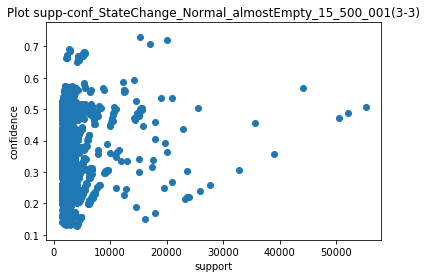

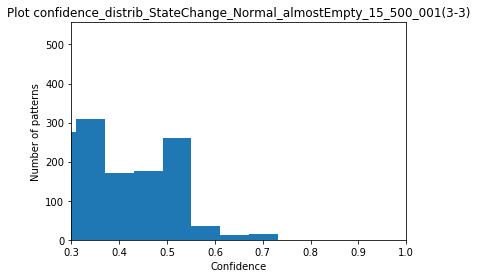

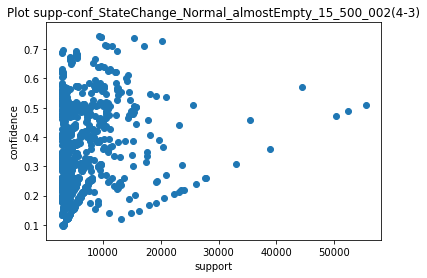

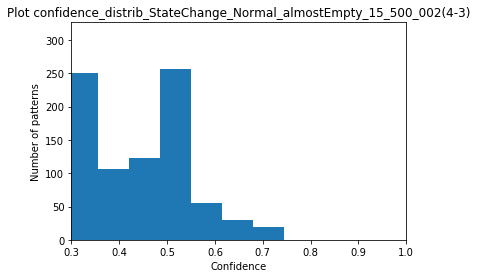

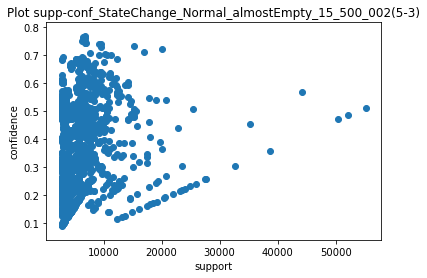

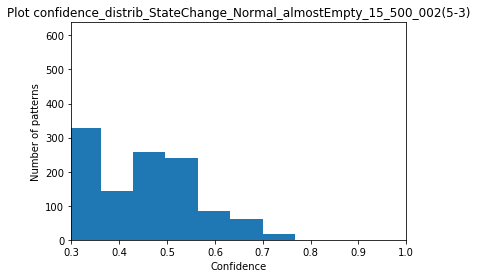

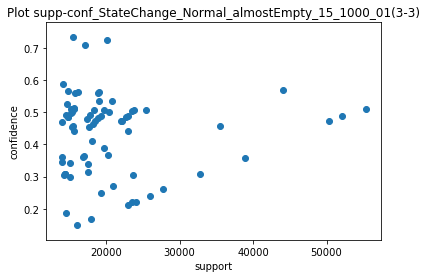

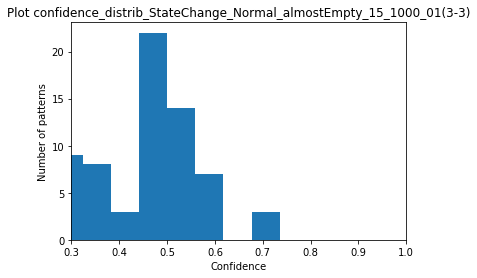

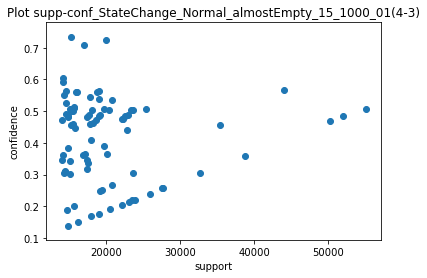

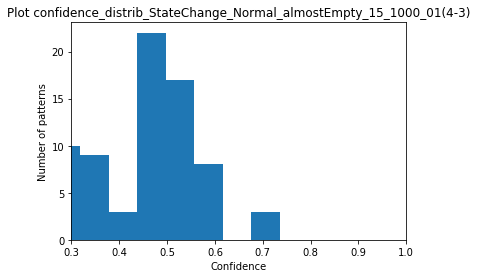

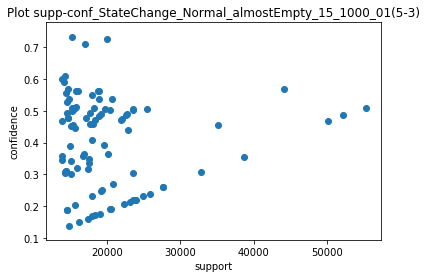

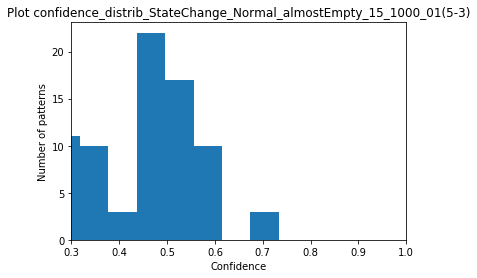

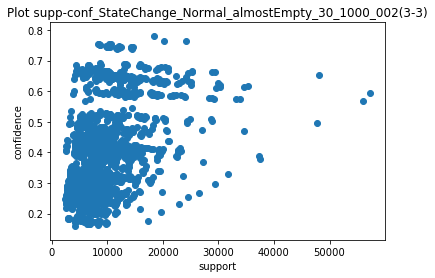

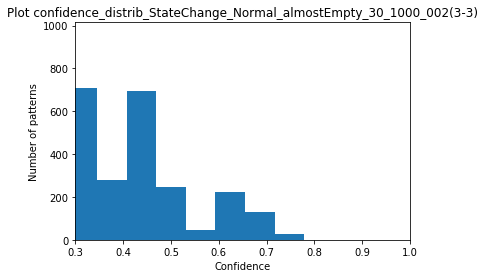

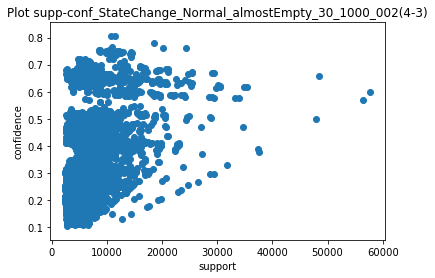

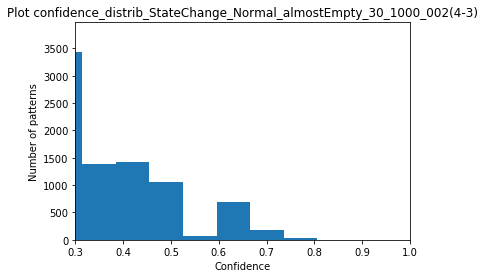

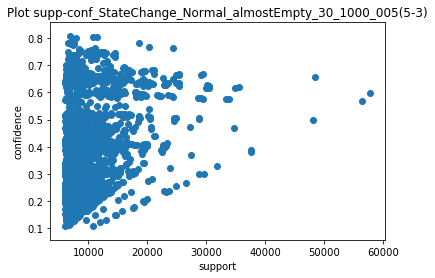

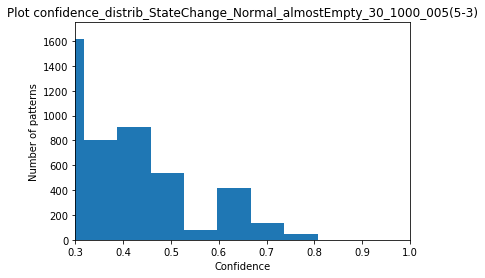

In [4]:
for i in range (0, len(inputPaths)):
    
    #the following path is to check the existence of the file
    path = Path(inputPaths[f"inputPath{i}"].split(':')[1])

    if path.is_file():
        #read file
        patterns = sc.textFile(inputPaths[f"inputPath{i}"]) #inputPath-i

        #remove file headers 
        patterns = patterns.zipWithIndex().filter(lambda kv: kv[1] > 1).keys()

        #filter patterns containing in the last element only elements with "_0"
        def filtering(line):
            s_list = ast.literal_eval(line)
            last = s_list[0][0][-1]
            list_of_last = last[0].split(',')
            for el in list_of_last:
                if "_0" not in el:
                    return False
            return True

        filtered_patterns = patterns.filter(filtering)

        #save filtered_patterns
        file = open(outputPaths[f"outputPath{i}"], "w") #output_file-i
        file.write('Filtered Pattern, Confidence-Frequence'+'\n')
        file.write(f'Total number of input patterns: {filtered_patterns.count()}'+'\n')
        for el in filtered_patterns.collect():  
            file.write(str(el)+ '\n')   
        file.close()


        #extract confidences list
        def extract_confidences(line):
            s_list = ast.literal_eval(line)
            confidence = s_list[1][0].split(' - ')[0]
            return float(confidence)

        confidences_list = filtered_patterns.map(extract_confidences).collect()

        #extract suppprts list
        def extract_supports(line):
            s_list = ast.literal_eval(line)
            support = s_list[1][0].split(' - ')[1]
            return int(support)

        supports_list = filtered_patterns.map(extract_supports).collect()

        #save support-confidence plot
        title = 'Plot ' + imgs_support_confidence[f"img_support_confidence{i}"].split('/')[-1][:-4]
        plt.scatter(supports_list, confidences_list)
        plt.xlabel('support') 
        plt.ylabel('confidence')
        _=plt.title(title)
        plt.savefig(imgs_support_confidence[f"img_support_confidence{i}"]) #img_support_confidence-i
        plt.show()
        
        #save plot of number of pattern with certaion confidence
        plt.hist(confidences_list)
        plt.xlabel('Confidence')
        plt.ylabel('Number of patterns')
        plt.title( 'Plot ' + imgs_confidence[f"img_confidence{i}"].split('/')[-1][:-4])
        plt.xlim(0.3,1)
        plt.savefig(imgs_confidence[f"img_confidence{i}"]) #img_confidence-i
        plt.show()

In [1]:
# !pwd 
# !zip -r ./Results_extraction.zip ./Results_extraction
# !zip -r ./Results_filtered_patterns.zip ./Results_filtered_patterns

# !zip -r ./Zips/tesi.zip ../bike_sharing
!zip -r ./Zips/tesi.zip ../bike_sharing 


updating: ../bike_sharing/ (stored 0%)
updating: ../bike_sharing/Results_extraction/ (stored 0%)
updating: ../bike_sharing/Results_extraction/AllStates/ (stored 0%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_30_1000_01(3-3)/ (stored 0%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_30_1000_01(3-3)/results_1000_01_ordered_by_support.txt (deflated 84%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_30_1000_01(3-3)/results_1000_01_ordered_by_confidence.txt (deflated 85%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_30_1000_01(3-3)/3-3-1000-01.jpg (deflated 20%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_30_1000_01(3-3)/.ipynb_checkpoints/ (stored 0%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_30_1000_01(3-3)/.ipynb_checkpoints/results_1000_01_ordered_by_confidence-checkpoint.txt (deflated 85%)
updating: ../bike_sharing/Results_extraction/AllStates/AllStates_15_1000_01